# Carbon Flux ML Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
import json
import re

warnings.simplefilter('ignore')

In [4]:

sys.path.append(os.path.abspath("../src"))
import process

In [12]:
akb_csv = r'..\data\akb.csv'
aku_csv = r'..\data\aku.csv'
atq_csv = r'..\data\atq.csv'
bnz_csv = r'..\data\bnz.csv'
eml_csv = r'..\data\eml.csv'
imh_csv = r'..\data\imh.csv'
iml_csv = r'..\data\iml.csv'
ncb_csv = r'..\data\ncb.csv'
ncu_csv = r'..\data\ncu.csv'
hcu_csv = r'..\data\hcu.csv'
hcb_csv = r'..\data\hcb.csv'
root_dir = r'..\output'

In [13]:
site_dict = {'akb': akb_csv, 'aku': aku_csv, 'atq': atq_csv, 'bnz': bnz_csv, 'eml': eml_csv,
             'imh': imh_csv, 'iml': iml_csv, 'ncb': ncb_csv, 'ncu': ncu_csv, 'hcu': hcu_csv, 'hcb': hcb_csv}
era5_features = ['st2', 'le', 'pres', 'h', 'rad', 'airt', 'ppt.roll', 'rh', 'vpd', 'ws']
site_features = ['sm1', 'filledTSOIL1', 'filledTSOIL2']

In [55]:
#model2: era5 model
features = era5_features
site_code = 'hcu'

In [56]:
site_df =  process.read_csv(site_dict[site_code])
# each site has three chambers, loop through each one
r = re.compile("^FD.*_Flux$", re.IGNORECASE) #case insensitive
srs_chambers_names = list(filter(r.match, list(site_df.columns)))
print(srs_chambers_names)

Index(['FD01_flux', 'FD02_flux', 'FD03_flux', 'SoilTEMP_5cm', 'SoilTEMP_15cm',
       'SoilTEMP_25cm', 'ATM_Temp', 'SoilTemp_15cm_01', 'SoilTemp_15cm_02',
       'sm1', 'VWC15cm_raw_01', 'VWC15cm_raw_02', 'soilt1', 'st2', 'le',
       'pres', 'h', 'rad', 'airt', 'precip', 'u', 'v', 'vwc1', 'vwc2', 'rh',
       'vpd', 'ws', 'ppt.roll', 'st1', 'month', 'filledsoilt'],
      dtype='object') 
rows= 61483
['FD01_flux', 'FD02_flux', 'FD03_flux']


In [57]:
chamber_name = srs_chambers_names[0]
save_dir = process.create_savedir(root_dir, site_code, chamber_name)

..\output\hcu_FD01_flux__240823


In [58]:
feature_df = site_df[features].copy(deep=True)
feature_df

,st2,le,pres,h,rad,airt,ppt.roll,rh,vpd,ws
timestamp,,,,,,,,,,
2016-08-28 08:00:00,11.828134,22.093516,98.307906,4.054219,167.300443,11.732996,0.000002,80.907353,0.263058,1.845914
2016-08-28 09:00:00,11.859369,64.135807,98.305320,36.322344,275.743359,13.093790,0.000002,71.048503,0.436209,2.313533
2016-08-28 10:00:00,11.946115,104.250373,98.381195,78.230122,376.476901,14.014368,0.000002,62.714006,0.596494,2.660038
2016-08-28 11:00:00,12.080530,131.036293,98.381574,115.814444,459.113012,14.948892,0.000003,55.544840,0.755472,2.905717
2016-08-28 12:00:00,12.251169,150.176415,98.377359,143.408976,517.506997,15.666101,0.000003,51.932297,0.855369,3.090836
...,...,...,...,...,...,...,...,...,...,...
2023-09-02 08:00:00,9.093057,41.616181,96.651391,-4.156250,18.758715,5.217020,0.010418,94.798528,0.046057,3.900796
2023-09-02 09:00:00,8.985605,52.862378,96.685418,-6.620312,30.416267,5.253961,0.010017,95.037859,0.044051,3.781591
2023-09-02 10:00:00,8.884286,90.586406,96.754246,-25.877083,60.036068,5.272943,0.009532,92.635438,0.065465,4.311806


In [59]:
flux_chamber_df = site_df[[chamber_name]].copy(deep=True)
# choose the features to use
feautres_to_use = era5_features
features_df = site_df[feautres_to_use].copy(deep=True)

# combine x,y 
input_dataset = flux_chamber_df.merge(features_df, left_index=True, right_index=True)
# split input dataset into tran test and inference
x_train, y_train, x_test, y_test, x_inference = process.dataset_split(input_dataset, chamber_name)

total data shape 61543
missing data index Index(['2016-08-31 19:00:00', '2016-09-01 08:00:00', '2016-09-01 18:00:00',
       '2016-09-05 18:00:00', '2016-09-05 20:00:00', '2016-09-05 21:00:00',
       '2016-09-05 22:00:00', '2016-09-06 00:00:00', '2016-09-06 01:00:00',
       '2016-09-06 02:00:00',
       ...
       '2023-08-30 10:00:00', '2023-08-30 20:00:00', '2023-08-30 21:00:00',
       '2023-08-31 10:00:00', '2023-08-31 23:00:00', '2023-09-01 00:00:00',
       '2023-09-01 10:00:00', '2023-09-02 06:00:00', '2023-09-02 07:00:00',
       '2023-09-02 08:00:00'],
      dtype='object', name='timestamp', length=34911)
available data shape (26622, 11)
train/test shape (21298, 11) (5317, 11)
training y shape (21298, 1)
training x shape (21298, 10)
testing y shape (5317, 1)
testing x shape (5317, 10)
inference x shape (34921, 10)


In [37]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
param_grid = {
                'n_estimators': [600,700,800,900],  #  number of trees
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4, 8],
                'max_features': ['auto', 'sqrt', 'log2'],
                'warm_start': [True, False]
                        }
rf = RandomForestRegressor()
grid_search = HalvingRandomSearchCV(estimator=rf, param_distributions=param_grid, cv=5, n_jobs=-1).fit(x_train, y_train)
best_params_= grid_search.best_params_
print (best_params_)

{'warm_start': True, 'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 30}


In [38]:
rf = RandomForestRegressor(**best_params_)
rf.fit(x_train, y_train)
r2 = rf.score(x_test, y_test)
r2 = round(r2, 3) 
print('R2:', r2)

R2: 0.602


In [40]:
# slope check
x_test_predict = rf.predict(x_test)
slope = np.polyfit(x_test_predict, y_test[chamber_name], 1)[0].round(3)
print ('slope =', slope)

slope = 1.214


In [41]:
# inference
model_inference = rf.predict(x_inference)
data_filled_colname = chamber_name + '_filled'

In [60]:
missingdata_index = input_dataset[input_dataset[chamber_name].isnull()].index
model_inference_reshape = np.expand_dims(model_inference, axis=1)
print (model_inference_reshape.shape)
filled_series = pd.DataFrame(model_inference_reshape).rename(columns={0:data_filled_colname})
filled_series.index = missingdata_index
original_data = input_dataset.filter([chamber_name]).copy(deep=True) # original data
original_data.loc[:] = np.nan # set all values to NaN only keep the shape
original_data.loc[missingdata_index] = filled_series # set the missing index to the filled values
filled_data_to_index = original_data.rename(columns={chamber_name:data_filled_colname})

original_index_name = filled_data_to_index.index.name # get the original index name

(34921, 1)


ValueError: Length mismatch: Expected axis has 34921 elements, new values have 34911 elements

In [61]:
dataset = input_dataset
chamber = chamber_name
missingdata_index = dataset[dataset[chamber].isnull()].index
# x_inference = dataset[dataset.index.isin(missingdata_index)].drop([
#         chamber], axis=1)
x_inference = dataset[dataset[chamber].isnull()].drop([chamber], axis=1)


print (len(x_inference),len(missingdata_index))

34911 34911


In [53]:
print(dataset.index.duplicated().sum())


81


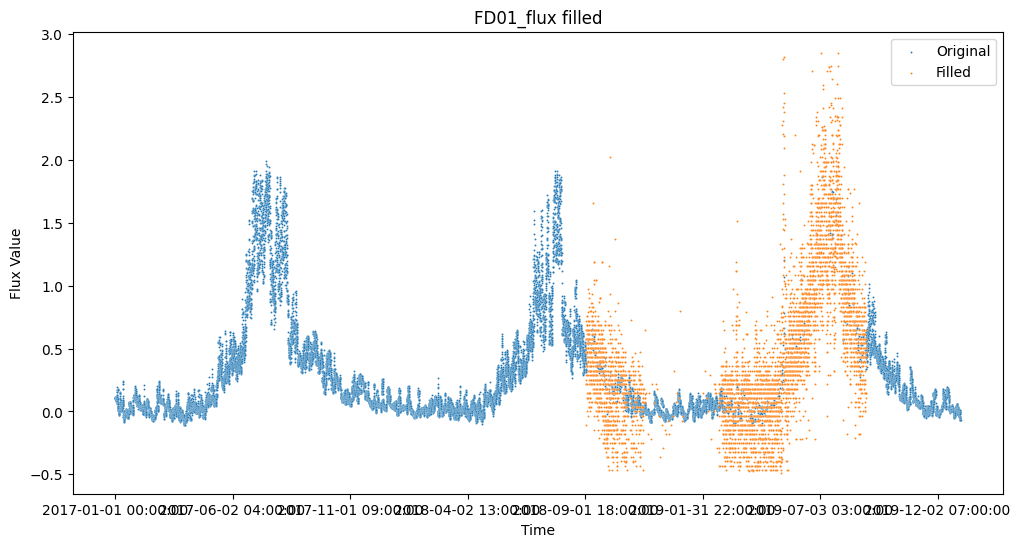

In [31]:
import seaborn as sns
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the 'Original' DataFrame
sns.scatterplot(data=filled_data_to_index, x=original_index_name, y=data_filled_colname, 
            label='Original', ax=ax, s=2)
# Plot the 'Filled' DataFrame on the same axis
sns.scatterplot(data=input_dataset, x=original_index_name, y=chamber_name, 
            label='Filled', ax=ax, s=2)

plt.title('{} filled'.format(chamber_name))
plt.xlabel('Time')
plt.ylabel('Flux Value')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

In [100]:
save_dir = process.create_savedir(ROOT_DIR, site_tofill, SRS_CHAMBER)
# create output csv
filled_gap = filled_data_original_masked.reset_index()[data_filled_colname]
original = dataset.reset_index()[SRS_CHAMBER]
output = pd.concat([original, filled_gap], axis=1)

output\akb_FD01_flux__240816


In [105]:
# save to file
filename = data_filled_colname + '_slope' + str(slope) + '_rs' + str(r2) + '.csv'
print (filename)
output.to_csv(save_dir + '/' + filename)

FD01_flux_filled_slope1.001_rs0.788.csv


In [106]:
figname = data_filled_colname + 'slope' + str(slope) + '_rs' + str(r2) + '.jpeg'
fig.savefig(save_dir + '/' + figname)

In [107]:
# counting rows
n_obs_spring, n_obs_summer, n_obs_autumn, n_obs_winter = process.count_by_seasons(flux_df.dropna())
n_filled_spring, n_filled_summer, n_filled_autumn, n_filled_winter = process.count_by_seasons(x_predict)

# output log
output_log =  {'MODEL' : 'Random Forest',
            'SITE' : site_tofill,
            'SRS_CHAMBER' : SRS_CHAMBER,
            'FEATURES' : features,
            'RSQUARE' : r2,
            'SLOPE' : slope,
            'RMSE' : rmse,
            'N_RMSE' : n_rmse,
            'MAE' : mae,
            'start_t' : flux_df.index[0],
            'end_t' : flux_df.index[-1],
            'n_filled' : len(x_predict),
            'n_observed' : len(flux_df) - len(x_predict),
            'n_obs_spring' : n_obs_spring,
            'n_obs_summer' : n_obs_summer,
            'n_obs_autumn' : n_obs_autumn,
            'n_obs_winter' : n_obs_winter,
            'n_filled_spring' : n_filled_spring,
            'n_filled_summer' : n_filled_summer,
            'n_filled_autumn' : n_filled_autumn,
            'n_filled_winter' : n_filled_winter
        }
output_log

#save parameters
with open(os.path.join(save_dir, 'output_log.json'), 'w') as fp:
    json.dump(output_log, fp)
print ('done')

done
